# Vizualise sentence embeddings

Ce que j'ai fait, c'est prendre toutes les phrases présentes sur la page Wikipédia https://en.wikipedia.org/wiki/Computer_network (155 phrases) et pour chacune d'elles je leur ai mis un label correspondant à la section dans lesquelles elles apparaissaient (15 sections sur la page). Ensuite j'encode chacune de ces phrases avec BERT ou NetBERT et je représente l'embedding d'une phrase par la moyenne des embeddings de ses mots. Je réduis ensuite la dimension des sentence embeddings de 768 à 2 ou 3 avec PCA/tsne et plot les 155 points en 2D/3D en mettant la couleur associé à la section dans laquelle la phrase apparaissait. Le but est de déterminer si les sentence embeddings des sections forment des clusters.

In [1]:
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from transformers import BertModel, BertTokenizer
from keras.preprocessing.sequence import pad_sequences

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

Using TensorFlow backend.


## Load sentences

In [4]:
def load_sentences(filepath):
    """
    """
    # Create dataframe.
    df = pd.read_csv(filepath)
    sentences = df.Sentence.values

    # Add classes ids column.
    classes = df.Label.unique()
    df['Label_id'] = df.apply(lambda row: np.where(classes == row.Label)[0][0], axis=1)

    # Print details.
    print('Number of sentences: {}\n'.format(df.shape[0]))
    print('Number of classes: {:,}'.format(len(classes)))
    for i, lab in enumerate(classes):
        print("  {} : {}".format(lab, i))

    # Example
    random.seed(42)
    print("\nExample:\n\n{}".format(random.choice(sentences)))
    return df, sentences


df, sentences = load_sentences('./data/computer_network.csv')
df.sample(10)

Number of sentences: 155

Number of classes: 15
  Computer network : 0
  History : 1
  Properties : 2
  Network packet : 3
  Network topology : 4
  Network links : 5
  Network nodes : 6
  Communication protocols : 7
  Geographic scale : 8
  Organizational scope : 9
  Routing : 10
  Network service : 11
  Network performance : 12
  Security : 13
  Views of networks : 14

Example:

Packets consist of two kinds of data: control information and user data (payload). The control information provides data the network needs to deliver the user data, for example, source and destination network addresses, error detection codes, and sequencing information. Typically, control information is found in packet headers and trailers, with payload data in between.


,Sentence,Label,Label_id
152,"Both users and administrators are aware, to va...",Views of networks,14
56,Cellular networks use several radio communicat...,Network links,5
145,End-to-end encryption (E2EE) is a digital comm...,Security,13
73,Wireless bridges: Can be used to join LANs or ...,Network nodes,6
4,"In the late 1950s, early networks of computers...",History,1
32,Common layouts are:,Network topology,4
25,A computer network facilitates interpersonal c...,Properties,2
93,A local area network (LAN) is a network that c...,Geographic scale,8
60,IP over Avian Carriers was a humorous April fo...,Network links,5
132,Circuit-switched networks: In circuit switched...,Network performance,12


## Encode

In [5]:
def encode_sentences(model_name_or_path, sentences):
    """
    Given a list of sentences an d a model, get the embeddings of theses sentences
    as the average of the word embeddings of the last layer.
    """
    print("   Loading pretrained model/tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
    model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True, cache_dir ='../_cache') # Will output all hidden_states.

    print("   Tokenizing sentences...")
    tokenized = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

    lengths = [len(i) for i in tokenized]
    max_len = max(lengths) if max(lengths) <= 512 else 512

    print("   Padding/Truncating sentences to {} tokens...".format(max_len))
    padded = pad_sequences(tokenized, maxlen=max_len, dtype="long", 
                          value=0, truncating="post", padding="post")

    print("   Creating attention masks...")
    attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.

    print("   Converting inputs to torch tensors...")
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print("   Encoding sentences...")
    with torch.no_grad():
        # output is a 2-tuple where:
        #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
        #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
        #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
        output = model(input_ids, attention_mask=attention_mask)

    # For each sentence, take the embeddings of its word from the last layer and represent that sentence by their average.
    last_hidden_states = output[0]
    sentence_embeddings = [torch.mean(embeddings[:torch.squeeze((masks == 1).nonzero(), dim=1).shape[0]], dim=0).numpy() for embeddings, masks in zip(last_hidden_states, attention_mask)]
    sentence_embeddings = np.array(sentence_embeddings)
    
    return sentence_embeddings
    

print("BERT-base")
bert_embeddings = encode_sentences('bert-base-cased', sentences)
print("NetBERT")
netbert_embeddings = encode_sentences('../_models/netbert-final/', sentences)

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 219 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 219 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...


## Visualize embeddings

### Tensorboard Projector

In [23]:
def generate_colors(x):
    """
    Generate x random colors.
    """
    return [tuple(np.random.uniform(low=0.0, high=1.0, size=3)) for i in range(x)]


def tensorboard_projector(df, sentence_embeddings):
    """
    """
    # Load SummaryWriter (will output to ./runs/ directory by default).
    writer = SummaryWriter()

    # Get the classes and generate one color for each.
    classes = df.Label.unique().tolist()

    # Associate each sentence with the color of its label.
    label_img = torch.zeros(len(sentence_embeddings), 3, 32, 32)
    colors = generate_colors(len(classes))
    for i in range(len(sentence_embeddings)):
        # Get color of that label.
        sentence_label = df.loc[i,'Label']
        idx = classes.index(sentence_label)
        color = colors[idx]

        # Set color.
        label_img[i,0,:,:] = color[0]
        label_img[i,1,:,:] = color[1]
        label_img[i,2,:,:] = color[2]

    # Write to tensorboard
    writer.add_embedding(sentence_embeddings, metadata=df.Sentence.values, label_img=label_img)

    # Close writer
    writer.close()


print("BERT-base")
tensorboard_projector(df, bert_embeddings)
print("NetBERT")
tensorboard_projector(df, netbert_embeddings)

### t-SNE+PCA

BERT-base
Cumulative explained variation for 50 principal components: 0.8569777011871338


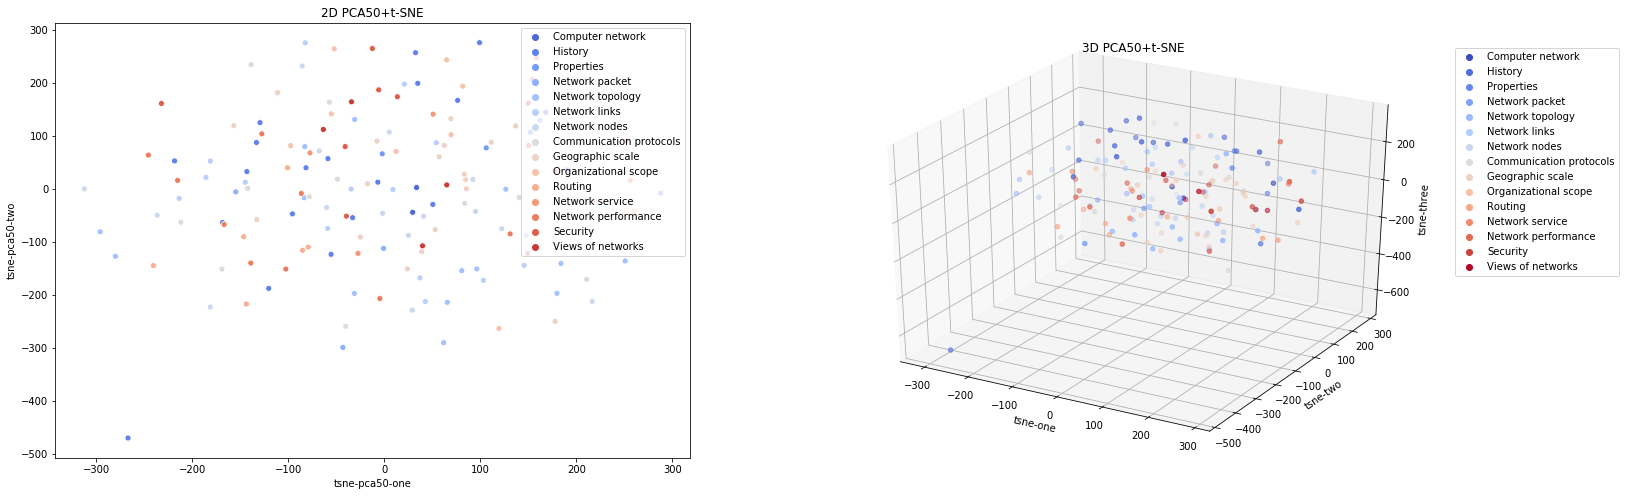

NetBERT
Cumulative explained variation for 50 principal components: 0.8157966732978821


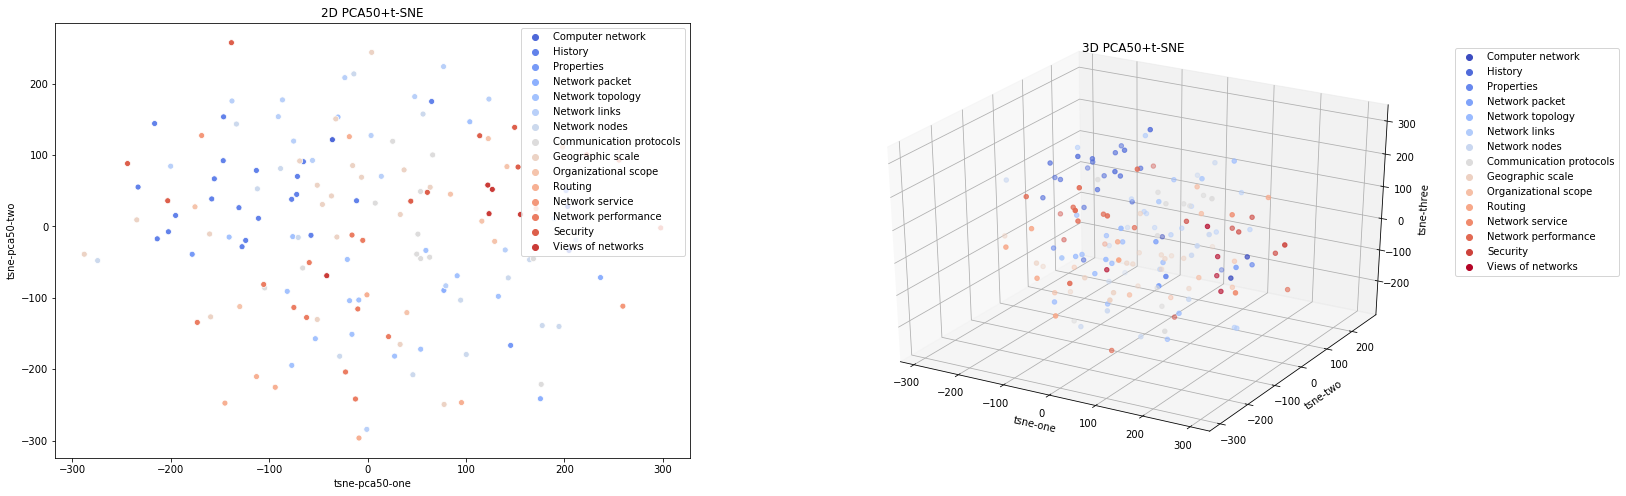

In [9]:
def plot_tsne(df, sentence_embeddings):
    """
    """
    # Use PCA to reduce dimensions to a number that's manageable for t-SNE
    pca_50 = PCA(n_components=50, random_state = 42)
    pca_result_50 = pca_50.fit_transform(sentence_embeddings)
    print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))


    # Reduce dimensionality to 2 with t-SNE.
    # Perplexity is roughly the number of close neighbors you expect a point to have. Our data is sparse, so we chose a small value, 10.
    # The KL divergence objective is non-convex, so the result is different depending on the seed used.
    tsne = TSNE(n_components=3, 
                perplexity=10, # usually in the range [5, 50] -> perplexity is related to the number of nearest neighbors (larger datasets usually require a larger perplexity).
                n_iter=2000, 
                learning_rate = 200, # usually in the range [10, 1000] -> If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours.
                random_state = 42, verbose=0)
    tsne_pca_results = tsne.fit_transform(pca_result_50)

    # Add results to dataframe
    pca50_tsne_df = df.copy(deep=True)
    pca50_tsne_df['tsne-pca50-one'] = tsne_pca_results[:,0]
    pca50_tsne_df['tsne-pca50-two'] = tsne_pca_results[:,1]
    pca50_tsne_df['tsne-pca50-three'] = tsne_pca_results[:,2]

    # PCA in 2D
    fig = plt.figure(figsize=(25,8))
    ax1 = fig.add_subplot(1, 2, 1)
    sns.scatterplot(
        x = pca50_tsne_df['tsne-pca50-one'], 
        y = pca50_tsne_df['tsne-pca50-two'],
        hue = pca50_tsne_df["Label"],
        palette = "coolwarm")
    ax1.set_title("2D PCA50+t-SNE")
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles=handles[1:], labels=labels[1:], loc='upper right', title="")

    # PCA in 3D
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    scatter = ax2.scatter(
        xs=pca50_tsne_df['tsne-pca50-one'],
        ys=pca50_tsne_df['tsne-pca50-two'],
        zs=pca50_tsne_df['tsne-pca50-three'],
        c=pca50_tsne_df["Label_id"],
        cmap='coolwarm')
    classes = df.Label.unique().tolist()
    handles,_ = scatter.legend_elements(num=len(classes))
    ax2.legend(handles, classes, loc="center left", title="", bbox_to_anchor=(1, 0.68))
    ax2.set_title("3D PCA50+t-SNE")
    ax2.set_xlabel('tsne-one')
    ax2.set_ylabel('tsne-two')
    ax2.set_zlabel('tsne-three')
    plt.show()
    return

print("BERT-base")
plot_tsne(df, bert_embeddings)
print("NetBERT")
plot_tsne(df, netbert_embeddings)


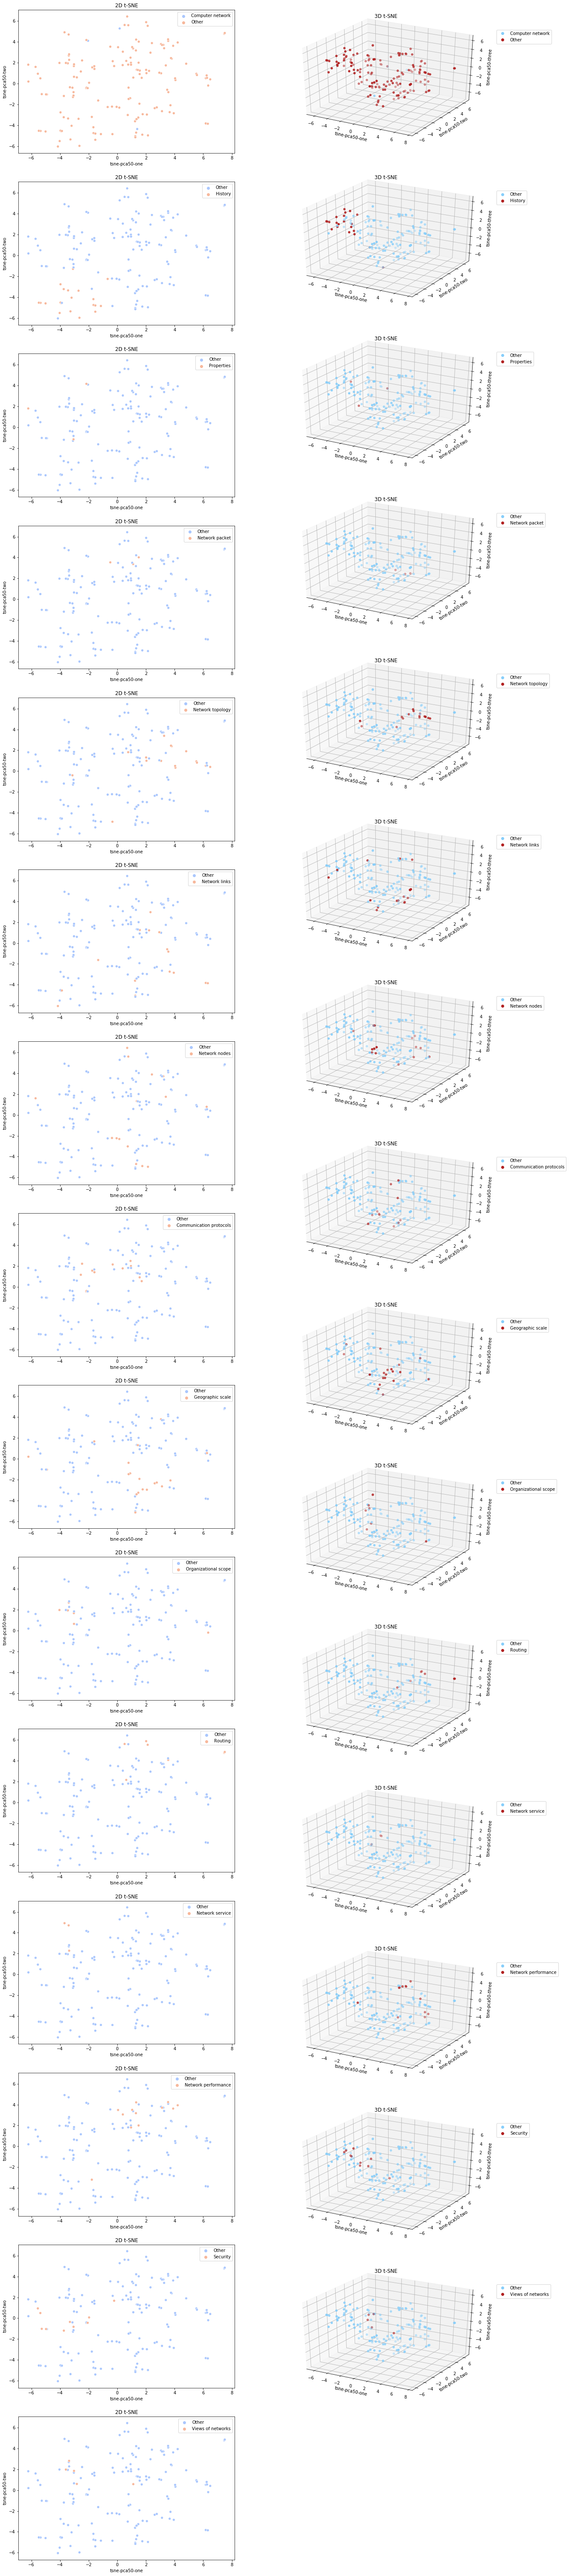

In [193]:
# Init figure.
fig = plt.figure(figsize=(20,110))
nb_classes = len(classes)


# Draw plots.
for i, cl in enumerate(classes):
    
    # Create temporary column 'Category' to distinguish from the current label and all others.
    tmp_df = pca50_tsne_df.copy(deep=True)
    tmp_df['Category'] = tmp_df['Label']
    tmp_df.loc[tmp_df['Label'] == cl, 'Category'] = cl
    tmp_df.loc[tmp_df['Label'] != cl, 'Category'] = 'Other'
    tmp_df['Category_id'] = tmp_df.apply(lambda row: np.where(tmp_df.Category.unique() == row.Category)[0][0], axis=1)
    
    # PCA in 2D.
    ax1 = fig.add_subplot(nb_classes, 2, (i*2)+1)
    sns.scatterplot(x = tmp_df['tsne-pca50-one'], 
                    y = tmp_df['tsne-pca50-two'],
                    hue = tmp_df["Category"],
                    palette = "coolwarm")
    ax1.set_title("2D t-SNE")
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles=handles[1:], labels=labels[1:], loc='upper right', title="")
    
    # PCA in 3D.
    ax2 = fig.add_subplot(nb_labels, 2, (i*2)+2, projection='3d')
    scatter = ax2.scatter(xs=tmp_df["tsne-pca50-one"], 
                      ys=tmp_df["tsne-pca50-two"], 
                      zs=tmp_df["tsne-pca50-three"],
                      c=tmp_df["Category_id"],
                      cmap=mpl.colors.ListedColormap(['lightskyblue', 'firebrick']))
    tmp_classes = tmp_df.Category.unique()
    handles,_ = scatter.legend_elements(num=len(tmp_classes))
    ax2.legend(handles, tmp_classes, loc="center left", title="", bbox_to_anchor=(1, 0.8))
    ax2.set_title("3D t-SNE")
    ax2.set_xlabel('tsne-pca50-one')
    ax2.set_ylabel('tsne-pca50-two')
    ax2.set_zlabel('tsne-pca50-three')
    
    
plt.show()